# Single-site LCOA from NetCDF weather

Runs the green ammonia plant optimisation for one user-chosen location using the NetCDF weather stacks in `data/`.

Notes:
- The NetCDF weather grid is 1° resolution; your input lat/lon will be snapped to the nearest available grid point.
- Outputs are saved under `results/` (CSV + PNG plots).

In [7]:
import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Make repo importable
repo_root = Path().resolve().parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

from model import main as plant_main
from model import run_global
from model import location_tools as lt

# ----------------
# USER PARAMETERS
# ----------------
# Pick a location (lat, lon). It will be snapped to the nearest 1° grid point available in the NetCDF files.
USER_LAT = -23.0
USER_LON = 133.0

# Snapshot aggregation and time-step (hours)
AGGREGATION_COUNT = 1
TIME_STEP_H = 1.0

# Optional cap for faster runs while iterating (set to None for full year)
MAX_SNAPSHOTS = 8760  # e.g. 168 = 1 week; None = full series

# Solver control (defaults align with model/main.py)
os.environ.setdefault('GREEN_LORY_SOLVER', os.environ.get('GREEN_LORY_SOLVER', 'gurobi'))
os.environ.setdefault('GREEN_LORY_SOLVER_LOG', '0')

WEATHER_DIR = repo_root / 'data'
OUTPUT_DIR = repo_root / 'results'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

In [8]:
def _min_positive_step(values: np.ndarray) -> float | None:
    unique_sorted = np.sort(np.unique(values.astype(float)))
    diffs = np.diff(unique_sorted)
    diffs = diffs[diffs > 0]
    if diffs.size == 0:
        return None
    return float(diffs.min())


def _nearest_coord(values: np.ndarray, target: float) -> float:
    values = values.astype(float)
    idx = int(np.abs(values - float(target)).argmin())
    return float(values[idx])


# Load NetCDF resources (lazy, avoids loading full stacks into memory)
nc = lt.all_locations(str(WEATHER_DIR), cache_resources=False)

# Inspect coordinate grid from whichever resource is present.
# IMPORTANT: don't use `a or b` with xarray objects (it triggers ambiguous truth-value errors).
resource = nc.resources.get("solar")
if resource is None:
    resource = nc.resources.get("wind")
if resource is None:
    resource = nc.resources.get("solar_tracking")
if resource is None:
    raise RuntimeError("No weather resources found in the NetCDF directory.")

lat_vals = resource["latitude"].values
lon_vals = resource["longitude"].values
lat_step = _min_positive_step(np.array(lat_vals))
lon_step = _min_positive_step(np.array(lon_vals))
print("NetCDF grid (from one resource):")
print("  latitude step:", lat_step, "range:", float(np.min(lat_vals)), "to", float(np.max(lat_vals)))
print("  longitude step:", lon_step, "range:", float(np.min(lon_vals)), "to", float(np.max(lon_vals)))

SNAPPED_LAT = _nearest_coord(np.array(lat_vals), USER_LAT)
SNAPPED_LON = _nearest_coord(np.array(lon_vals), USER_LON)
print("Requested location:", (USER_LAT, USER_LON))
print("Snapped to grid:", (SNAPPED_LAT, SNAPPED_LON))

INFO:model.location_tools:Loaded solar stack (3 files)


INFO:model.location_tools:Loaded windpowers stack (3 files)
INFO:model.location_tools:Loaded solartracking stack (3 files)


NetCDF grid (from one resource):
  latitude step: 1.0 range: -90.0 to 89.0
  longitude step: 1.0 range: -180.0 to 179.0
Requested location: (-23.0, 133.0)
Snapped to grid: (-23.0, 133.0)


In [9]:
# Build the weather frame for this site (uses nearest gridpoint selection internally as well)
weather_frame = run_global._build_weather_frame(
    nc,
    lat=SNAPPED_LAT,
    lon=SNAPPED_LON,
    aggregation_count=AGGREGATION_COUNT,
)
if MAX_SNAPSHOTS is not None:
    weather_frame = weather_frame.iloc[:MAX_SNAPSHOTS].copy()

print('Weather frame columns:', list(weather_frame.columns))
print('Snapshots:', len(weather_frame))
display(weather_frame.head())

Weather frame columns: ['wind', 'solar', 'solar_tracking', 'grid', 'ramp_dummy']
Snapshots: 8760


,wind,solar,solar_tracking,grid,ramp_dummy
0,0.046595,0.561972,0.703333,0.0,1.0
1,0.000000,0.707093,0.782422,0.0,1.0
2,0.000000,0.810035,0.835025,0.0,1.0
3,0.000000,0.866190,0.866891,0.0,1.0
4,0.035095,0.872786,0.887061,0.0,1.0


In [10]:
# Run optimisation (keeps solved Network object in memory for plotting)
network = plant_main.generate_network(
    len(weather_frame),
    repo_root / 'basic_ammonia_plant',
    aggregation_count=AGGREGATION_COUNT,
    time_step=TIME_STEP_H,
)

results = plant_main.main(
    n=network,
    weather_data=weather_frame,
    multi_site=True,
    aggregation_count=AGGREGATION_COUNT,
    time_step=TIME_STEP_H,
)

print('Solved.')
print('LCOA (USD/t):', results.get('lcoa_usd_per_t'))
display(pd.Series(results).sort_index())

INFO:pypsa.network.io:New version 1.0.6 available! (Current: 1.0.5)
INFO:pypsa.network.io:Imported network 'Basic Ammonia Plant v1' has buses, generators, links, loads, stores
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
 - LogToConsole: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 265.09it/s]
INFO:linopy.io: Writing time: 0.62s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-12-10


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-12-10


Read LP format model from file /private/var/folders/6b/x50zyszd41z391jpwblh3ryh0000gn/T/linopy-problem-onpl44wo.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/6b/x50zyszd41z391jpwblh3ryh0000gn/T/linopy-problem-onpl44wo.lp


Reading time = 0.53 seconds


INFO:gurobipy:Reading time = 0.53 seconds


obj: 429267 rows, 183975 columns, 879878 nonzeros


INFO:gurobipy:obj: 429267 rows, 183975 columns, 879878 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 183975 primals, 429267 duals
Objective: 7.17e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Link-ext-p-ramp_limit_up, Link-ext-p-ramp_limit_down, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance, battery_interface_balance, compressed_h2_cycling_limit, ammonia_synthesis_ramp_down, ammonia_synthesis_ramp_up were not assigned to the network.


Solved.
LCOA (USD/t): 716.735395498841


accumulated_penalty                              0.000000e+00
ammonia                                          2.205118e+06
ammonia_synthesis                                9.230716e+03
annual_ammonia_demand_mwh                        6.250000e+07
annual_ammonia_production_t                      1.000000e+07
battery                                          0.000000e+00
battery_interface_in                             6.886073e+00
battery_interface_out                            6.817212e+00
capital_cost_share_pct                           9.927810e+01
compressed_hydrogen_store                        5.971878e+04
cost_share_ammonia_store_pct                     1.880958e+00
cost_share_ammonia_synthesis_pct                 1.527183e+01
cost_share_battery_pct                           0.000000e+00
cost_share_electrolyser_pct                      1.525978e+01
cost_share_hydrogen_compression_pct              1.335125e-02
cost_share_hydrogen_store_pct                    2.546995e+00
cost_sha

In [11]:
# Save outputs
tag = f'lat{SNAPPED_LAT:+06.1f}_lon{SNAPPED_LON:+07.1f}'.replace('+', '').replace('.', 'p')
results_path = OUTPUT_DIR / f'single_site_{tag}_results.csv'
weather_path = OUTPUT_DIR / f'single_site_{tag}_weather_frame.csv'

pd.Series(results).to_csv(results_path, header=['value'])
weather_frame.to_csv(weather_path, index=False)

print('Saved results to:', results_path)
print('Saved weather frame to:', weather_path)
print('Note: capacities/dispatch are stored in the in-memory `network` object (PyPSA).')

Saved results to: /Users/carlopalazzi/programming/pypsa_models/green-lory/results/single_site_lat-023p0_lon0133p0_results.csv
Saved weather frame to: /Users/carlopalazzi/programming/pypsa_models/green-lory/results/single_site_lat-023p0_lon0133p0_weather_frame.csv
Note: capacities/dispatch are stored in the in-memory `network` object (PyPSA).


Saved plot to: /Users/carlopalazzi/programming/pypsa_models/green-lory/results/single_site_lat-023p0_lon0133p0_profiles.png


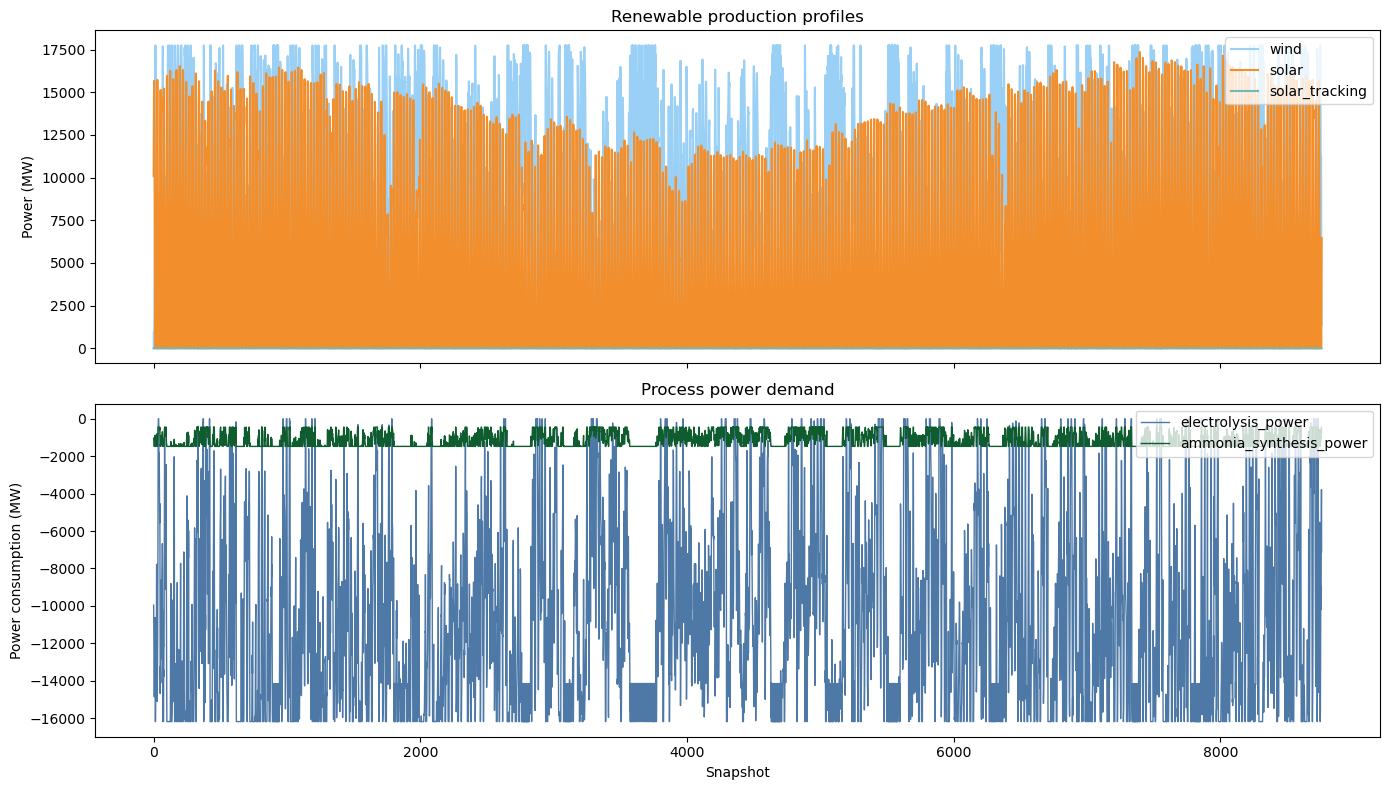

In [12]:
# Plot profiles (similar to dev_smoke_tests.ipynb)
timeline_df = pd.DataFrame(index=network.snapshots)

for gen_name in ('wind', 'solar', 'solar_tracking'):
    if gen_name in getattr(network.generators_t, 'p', pd.DataFrame()).columns:
        timeline_df[gen_name] = network.generators_t.p[gen_name]

if hasattr(network, 'links_t') and hasattr(network.links_t, 'p0'):
    if 'electrolysis' in network.links_t.p0.columns:
        timeline_df['electrolysis_power'] = -network.links_t.p0['electrolysis']
    if 'ammonia_synthesis' in network.links_t.p0.columns:
        timeline_df['ammonia_synthesis_power'] = -network.links_t.p0['ammonia_synthesis']

palette = {
    'solar': '#f28e2b',
    'wind': '#9ad0f5',
    'solar_tracking': '#76b7b2',
    'electrolysis_power': '#4e79a7',
    'ammonia_synthesis_power': '#0f5c2f',
}

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
gen_cols = [c for c in ('wind', 'solar', 'solar_tracking') if c in timeline_df]
if gen_cols:
    ordered_gen_cols = sorted(gen_cols, key=lambda c: timeline_df[c].abs().mean(), reverse=True)
    colors = [palette.get(col, None) for col in ordered_gen_cols]
    timeline_df[ordered_gen_cols].plot(ax=axes[0], color=colors)
    axes[0].set_ylabel('Power (MW)')
    axes[0].set_title('Renewable production profiles')
    axes[0].legend(loc='upper right')
else:
    axes[0].set_visible(False)

consumption_cols = [c for c in ('electrolysis_power', 'ammonia_synthesis_power') if c in timeline_df]
if consumption_cols:
    colors = [palette.get(col, None) for col in consumption_cols]
    timeline_df[consumption_cols].plot(ax=axes[1], linestyle='-', linewidth=1.0, color=colors)
    axes[1].set_ylabel('Power consumption (MW)')
    axes[1].set_title('Process power demand')
    axes[1].legend(loc='upper right')
axes[-1].set_xlabel('Snapshot')
plt.tight_layout()

plot_path = OUTPUT_DIR / f'single_site_{tag}_profiles.png'
fig.savefig(plot_path, dpi=150)
print('Saved plot to:', plot_path)